# Project Mcnulty

Prediction: Home Team Match Outcome

Load data, downloaded from Kaggle and clean up.

PART IV  - Run Classification Models on goal features 'minus' draw 'plus' win streak.
In this notebook you will also find csv files used for d3 visualizations.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import sqlite3
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
data = sqlite3.connect('/Users/keerthipamulaparthy/Documents/metis/projects/Project3_McNulty/database.sqlite')

In [2]:
df_raw = pd.read_sql_query(r"""SELECT A.id AS id, A.date AS date, country_id, league_id, season, stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B.buildUpPlaySpeed AS H_bUPS,C.buildUpPlaySpeed AS A_bUPS,B.buildUpPlayDribblingClass AS H_bUPDC, C.buildUpPlayDribblingClass AS A_bUPDC,B.buildUpPlayPassing AS H_bUPP, C.buildUpPlayPassing AS A_bUPP,B.buildUpPlayPositioningClass AS H_bUPPosC, C.buildUpPlayPositioningClass AS A_bUPPosC,B.chanceCreationPassing AS H_cCP, C.chanceCreationPassing AS A_cCP,B.chanceCreationCrossing AS H_cCC, C.chanceCreationCrossing AS A_cCC,B.chanceCreationShooting AS H_cCS, C.chanceCreationShooting AS A_cCS,B.chanceCreationPositioningClass AS H_cCPosC, C.chanceCreationPositioningClass AS A_cCPosC,B.defencePressure AS H_dP, C.defencePressure AS A_dP,B.defenceAggression AS H_dA, C.defenceAggression AS A_dA,B.defenceTeamWidth AS H_dTW, C.defenceTeamWidth AS A_dTW,B.defenceDefenderLineClass AS H_dDLC, C.defenceDefenderLineClass AS A_dDLC FROM Match A JOIN Team_Attributes B ON A.home_team_api_id = B.team_api_id JOIN Team_Attributes C ON A.away_team_api_id = C.team_api_id WHERE substr(A.date,0,5)=substr(B.date,0,5) and substr(A.date,0,5)=substr(C.date,0,5) and season='2014/2015'""", data)


**Get names of teams for D3**

In [6]:
country_name = pd.read_sql_query(r"""SELECT country_id, date, match_api_id, home_team_api_id, away_team_api_id, name FROM Match JOIN Country ON Match.country_id = Country.id WHERE season='2014/2015'""",data)

In [7]:
country_name.head(),len(country_name)

(   country_id                 date  match_api_id  home_team_api_id  \
 0           1  2014-07-25 00:00:00       1717817              9985   
 1           1  2014-07-26 00:00:00       1717818              8475   
 2           1  2014-07-26 00:00:00       1717819              9984   
 3           1  2014-07-26 00:00:00       1717820              9989   
 4           1  2014-07-26 00:00:00       1717821             10001   
 
    away_team_api_id     name  
 0              9986  Belgium  
 1              8342  Belgium  
 2              9991  Belgium  
 3              8573  Belgium  
 4              9994  Belgium  , 3325)

In [8]:
away_name = pd.read_sql_query(r"""SELECT date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal,team_api_id, team_long_name, team_short_name FROM Match JOIN Team ON Match.away_team_api_id = Team.team_api_id WHERE season='2014/2015'""", data)

len(away_name)

3325

In [9]:
team_names_result = pd.concat([away_name,country_name], axis =1 )

In [10]:
len(team_names_result)

3325

In [11]:
team_names_result.columns 

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'team_api_id', u'team_long_name',
       u'team_short_name', u'country_id', u'date', u'match_api_id',
       u'home_team_api_id', u'away_team_api_id', u'name'],
      dtype='object')

In [12]:
team_names_result.columns = ['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'team_api_id', 'team_long_name',
       'team_short_name','country_id', 'del-date', 'del-match_api_id',
       'del-home_team_api_id', 'delaway_team_api_id', 'name']

In [13]:
team_namesfinal = team_names_result.loc[:,['date','away_team_api_id','team_long_name','team_short_name','name']]

In [14]:
team_namesfinal.head()

,date,away_team_api_id,team_long_name,team_short_name,name
0,2014-07-25 00:00:00,9986,Sporting Charleroi,CHA,Belgium
1,2014-07-26 00:00:00,8342,Club Brugge KV,CLB,Belgium
2,2014-07-26 00:00:00,9991,KAA Gent,GEN,Belgium
3,2014-07-26 00:00:00,8573,KV Oostende,OOS,Belgium
4,2014-07-26 00:00:00,9994,Sporting Lokeren,LOK,Belgium


In [15]:
team_namesfinal2 = team_namesfinal.loc[:,['team_long_name','team_short_name','name']]

In [16]:
team_namesfinal2.columns = ['name','key','city']

In [17]:
colors = ["#13482D","#DF5E37","#E9472C","#092048","#3478A8","#AA003C","#FFB612","#3B0160","#003B48","#C11242","#17397D","#9D002B","#0D265A","#0C371D","#183F7D","#D2B887","#2E2180","#225B9A","#227476","#102A61","#0C2340","#B31B34","#276AAF","#000000","#C33319","#E7392D","#5E0610","#D60A0B","#DAA241","#0F2D5D","#B20040","#132C62"]

In [23]:
team_namesfinal2.head()

,key,name,city
0,AAR,FC Aarau,Switzerland
1,ABE,Aberdeen,Scotland
2,ACA,Académica de Coimbra,Portugal
3,ACM,Milan,Italy
4,AJA,Ajax,Netherlands


In [19]:
colors = colors + colors + colors + colors + colors + colors

In [20]:
team_namesfinal2 = team_namesfinal2.groupby(['key'],as_index=False).min()

In [21]:
d = {'teams': []}
for i in range(len(team_namesfinal2)):
    d1 = {"akey": team_namesfinal2.key[i], "cname": team_namesfinal2.city[i], "bcity":team_namesfinal2.name[i], "dcolor":colors[i]}
    d['teams'].append(d1)

In [22]:
import json
with open('soccer.json', 'w') as fp:
    json.dump(d, fp)

**Get match on match goal scoring probabilities for home team and away team**

Join two dataframes to get home team and away team names, and calculate probabilities.

In [25]:
away_name.columns = ['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'team_api_id', 'away_team_long_name',
       'away_team_short_name']
away_name.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'team_api_id',
       u'away_team_long_name', u'away_team_short_name'],
      dtype='object')

In [26]:
df_team = pd.read_sql_query(r"""SELECT * FROM Match JOIN Team ON Match.home_team_api_id = Team.team_api_id WHERE season='2014/2015'""", data)

df_team.columns

Index([u'id', u'country_id', u'league_id', u'season', u'stage', u'date',
       u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal',
       ...
       u'GBD', u'GBA', u'BSH', u'BSD', u'BSA', u'id', u'team_api_id',
       u'team_fifa_api_id', u'team_long_name', u'team_short_name'],
      dtype='object', length=120)

In [27]:
df_team = df_team.drop(['GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'id',
       'team_fifa_api_id','league_id','stage'],axis = 1)


In [28]:
df_team = df_team.drop(['SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH','home_player_X1', 'home_player_X2'],axis = 1)

In [29]:
df_team = df_team.drop(['home_player_X3','home_player_X4','home_player_X5','home_player_X6','home_player_X7','home_player_X8','home_player_X9','home_player_X10','home_player_X11','away_player_X1','away_player_X2','away_player_X3','away_player_X4','away_player_X5','away_player_X6','away_player_X7','away_player_X8','away_player_X9','away_player_X10','away_player_X11','home_player_Y1','home_player_Y2','home_player_Y3','home_player_Y4','home_player_Y5','home_player_Y6','home_player_Y7','home_player_Y8','home_player_Y9','home_player_Y10','home_player_Y11','away_player_Y1','away_player_Y2','away_player_Y3','away_player_Y4','away_player_Y5','away_player_Y6','away_player_Y7','away_player_Y8','away_player_Y9','away_player_Y10','away_player_Y11','home_player_1','home_player_2','home_player_3','home_player_4','home_player_5','home_player_6','home_player_7','home_player_8','home_player_9','home_player_10','home_player_11','away_player_1','away_player_2','away_player_3','away_player_4','away_player_5','away_player_6','away_player_7','away_player_8','away_player_9','away_player_10','away_player_11','goal', 'shoton', 'shotoff','foulcommit','card','cross','corner','possession'],axis = 1)

In [30]:
df_team = df_team.drop(['B365H',
       'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA'],axis = 1)

In [31]:
df_team['home_team_api_id'] == df_team['team_api_id']

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
3295    True
3296    True
3297    True
3298    True
3299    True
3300    True
3301    True
3302    True
3303    True
3304    True
3305    True
3306    True
3307    True
3308    True
3309    True
3310    True
3311    True
3312    True
3313    True
3314    True
3315    True
3316    True
3317    True
3318    True
3319    True
3320    True
3321    True
3322    True
3323    True
3324    True
dtype: bool

In [32]:
df_team.head()

,country_id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,team_api_id,team_long_name,team_short_name
0,1,2014/2015,2014-07-25 00:00:00,1717817,9985,9986,3,0,9985,Standard de Liège,STL
1,1,2014/2015,2014-07-26 00:00:00,1717818,8475,8342,0,2,8475,Waasland-Beveren,WAA
2,1,2014/2015,2014-07-26 00:00:00,1717819,9984,9991,0,0,9984,KSV Cercle Brugge,CEB
3,1,2014/2015,2014-07-26 00:00:00,1717820,9989,8573,2,0,9989,Lierse SK,LIE
4,1,2014/2015,2014-07-26 00:00:00,1717821,10001,9994,1,0,10001,KVC Westerlo,WES


In [33]:
df_raw.head()

,id,date,country_id,league_id,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
0,1249,2014-07-25 00:00:00,1,1,2014/2015,1,1717817,9985,9986,3,...,Organised,Organised,45,42,54,48,52,49,Cover,Cover
1,1250,2014-07-26 00:00:00,1,1,2014/2015,1,1717818,8475,8342,0,...,Organised,Organised,25,51,37,50,35,57,Cover,Cover
2,1251,2014-07-26 00:00:00,1,1,2014/2015,1,1717819,9984,9991,0,...,Organised,Organised,59,55,47,59,62,52,Cover,Cover
3,1252,2014-07-26 00:00:00,1,1,2014/2015,1,1717820,9989,8573,2,...,Organised,Organised,38,42,49,47,65,44,Cover,Cover
4,1254,2014-07-27 00:00:00,1,1,2014/2015,1,1717822,8203,9987,3,...,Organised,Organised,42,47,51,45,52,55,Cover,Cover


In [34]:
len(df_raw),len(df_team)

(3081, 3325)

In [35]:
df_raw.duplicated(),df_team.duplicated()

(0       False
 1       False
 2       False
 3       False
 4       False
 5       False
 6       False
 7       False
 8       False
 9       False
 10      False
 11      False
 12      False
 13      False
 14      False
 15      False
 16      False
 17      False
 18      False
 19      False
 20      False
 21      False
 22      False
 23      False
 24      False
 25      False
 26      False
 27      False
 28      False
 29      False
         ...  
 3051    False
 3052    False
 3053    False
 3054    False
 3055    False
 3056    False
 3057    False
 3058    False
 3059    False
 3060    False
 3061    False
 3062    False
 3063    False
 3064    False
 3065    False
 3066    False
 3067    False
 3068    False
 3069    False
 3070    False
 3071    False
 3072    False
 3073    False
 3074    False
 3075    False
 3076    False
 3077    False
 3078    False
 3079    False
 3080    False
 dtype: bool, 0       False
 1       False
 2       False
 3       False
 4       Fal

In [36]:
df_raw.columns

Index([u'id', u'date', u'country_id', u'league_id', u'season', u'stage',
       u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'H_bUPS', u'A_bUPS', u'H_bUPDC',
       u'A_bUPDC', u'H_bUPP', u'A_bUPP', u'H_bUPPosC', u'A_bUPPosC', u'H_cCP',
       u'A_cCP', u'H_cCC', u'A_cCC', u'H_cCS', u'A_cCS', u'H_cCPosC',
       u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA', u'A_dA', u'H_dTW', u'A_dTW',
       u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [37]:
df_team.columns

Index([u'country_id', u'season', u'date', u'match_api_id', u'home_team_api_id',
       u'away_team_api_id', u'home_team_goal', u'away_team_goal',
       u'team_api_id', u'team_long_name', u'team_short_name'],
      dtype='object')

In [38]:
df_2014 = df_raw.reindex(columns = ['date', 
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'hometeam_outcome', 'HT_goalsfor',
    'HT_goalsagainst','AT_goalsfor','AT_goalsagainst'
    ,'H_bUPS','A_bUPS', 'H_bUPDC', 'A_bUPDC', 'H_bUPP', 'A_bUPP', 'H_bUPPosC',
       'A_bUPPosC', 'H_cCP', 'A_cCP', 'H_cCC', 'A_cCC', 'H_cCS',
       'A_cCS', 'H_cCPosC', 'A_cCPosC', 'H_dP', 'A_dP', 'H_dA', 'A_dA',
       'H_dTW', 'A_dTW', 'H_dDLC', 'A_dDLC'])


In [39]:
df_team = df_team.reindex(columns = ['country_id', 'season', 'date', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_team_goal', 'away_team_goal',
       'team_api_id', 'team_long_name', 'team_short_name'])

In [40]:
away_name.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'team_api_id',
       u'away_team_long_name', u'away_team_short_name'],
      dtype='object')

In [41]:
away_name = away_name.reindex(columns = ['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'team_api_id',
       'away_team_long_name', 'away_team_short_name'])

In [42]:
home_away = pd.concat([df_team,away_name],axis = 1)

In [43]:
home_away.columns

Index([u'country_id', u'season', u'date', u'match_api_id', u'home_team_api_id',
       u'away_team_api_id', u'home_team_goal', u'away_team_goal',
       u'team_api_id', u'team_long_name', u'team_short_name', u'date',
       u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'team_api_id',
       u'away_team_long_name', u'away_team_short_name'],
      dtype='object')

In [44]:
home_away = home_away.drop(['country_id', u'season',u'match_api_id', 'home_team_api_id','away_team_api_id', 'team_api_id', 'match_api_id', 'home_team_api_id',
'away_team_api_id','team_api_id'],axis = 1)

In [45]:
home_away.columns

Index([u'date', u'home_team_goal', u'away_team_goal', u'team_long_name',
       u'team_short_name', u'date', u'home_team_goal', u'away_team_goal',
       u'away_team_long_name', u'away_team_short_name'],
      dtype='object')

In [46]:
home_away.columns = ['date', 'home_team_goal','away_team_goal', 'HT_long_name',
       'HT_short_name', 'del_date', 'del_home_team_goal',
       'del_away_team_goal', 'AT_long_name', 'AT_short_name']

In [47]:
home_away.columns

Index([u'date', u'home_team_goal', u'away_team_goal', u'HT_long_name',
       u'HT_short_name', u'del_date', u'del_home_team_goal',
       u'del_away_team_goal', u'AT_long_name', u'AT_short_name'],
      dtype='object')

In [48]:
home_away = home_away.drop([ 'del_date',
       'del_home_team_goal', 'del_away_team_goal'],axis = 1)

In [49]:
home_away.head()

,date,home_team_goal,away_team_goal,HT_long_name,HT_short_name,AT_long_name,AT_short_name
0,2014-07-25 00:00:00,3,0,Standard de Liège,STL,Sporting Charleroi,CHA
1,2014-07-26 00:00:00,0,2,Waasland-Beveren,WAA,Club Brugge KV,CLB
2,2014-07-26 00:00:00,0,0,KSV Cercle Brugge,CEB,KAA Gent,GEN
3,2014-07-26 00:00:00,2,0,Lierse SK,LIE,KV Oostende,OOS
4,2014-07-26 00:00:00,1,0,KVC Westerlo,WES,Sporting Lokeren,LOK


In [50]:
home_away['date'] = pd.to_datetime(home_away['date'])

In [51]:
#df['Week_Number'] = df['Date'].dt.week
home_away['week_num'] = home_away['date'].dt.week

In [52]:
home_away.tail()

,date,home_team_goal,away_team_goal,HT_long_name,HT_short_name,AT_long_name,AT_short_name,week_num
3320,2014-09-23,3,1,FC Basel,BAS,FC Vaduz,VAD,39
3321,2014-09-23,3,2,FC Thun,THU,FC Luzern,LUZ,39
3322,2014-09-24,3,0,FC St. Gallen,GAL,Grasshopper Club Zürich,GRA,39
3323,2014-09-24,0,0,FC Zürich,ZUR,FC Aarau,AAR,39
3324,2014-09-24,0,1,FC Sion,SIO,BSC Young Boys,YB,39


In [53]:
home_away = home_away.sort_values('date')


In [54]:
home_away['tot_goals'] = home_away['home_team_goal'] + home_away['away_team_goal']

In [55]:
home_away = home_away.sort_values('date')

In [56]:
home_away['away_prob'] = home_away['away_team_goal']/home_away['tot_goals']
home_away['home_prob'] = home_away['home_team_goal']/home_away['tot_goals']

In [57]:
home_away.head()

,date,home_team_goal,away_team_goal,HT_long_name,HT_short_name,AT_long_name,AT_short_name,week_num,tot_goals,away_prob,home_prob
1998,2014-07-18,1,1,Górnik Łęczna,LEC,Wisła Kraków,WIS,29,2,0.500000,0.500000
1997,2014-07-18,2,3,Podbeskidzie Bielsko-Biała,POD,Pogoń Szczecin,POG,29,5,0.600000,0.400000
1992,2014-07-19,0,1,Legia Warszawa,LEG,GKS Bełchatów,BEL,29,1,1.000000,0.000000
1994,2014-07-19,2,2,Jagiellonia Białystok,BIA,Lechia Gdańsk,LGD,29,4,0.500000,0.500000
3145,2014-07-19,1,2,FC Aarau,AAR,FC Basel,BAS,29,3,0.666667,0.333333


In [59]:
#soccer_teams - df table that will be converted to csv for d3
soccer_teams = home_away.loc[:,['week_num','AT_short_name','away_prob','home_prob','HT_short_name']]
soccer_teams.head()


,week_num,AT_short_name,away_prob,home_prob,HT_short_name
1998,29,WIS,0.500000,0.500000,LEC
1997,29,POG,0.600000,0.400000,POD
1992,29,BEL,1.000000,0.000000,LEG
1994,29,LGD,0.500000,0.500000,BIA
3145,29,BAS,0.666667,0.333333,AAR


In [62]:
soccer_teams.columns = ['week','away','away_prob','home_prob','home']
soccer_teams.head()

,week,away,away_prob,home_prob,home
1998,29,WIS,0.500000,0.500000,LEC
1997,29,POG,0.600000,0.400000,POD
1992,29,BEL,1.000000,0.000000,LEG
1994,29,LGD,0.500000,0.500000,BIA
3145,29,BAS,0.666667,0.333333,AAR


In [179]:
#soccer_teams['week'] -= 1

In [181]:
#soccer_teams = soccer_teams.dropna().sort('week')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [63]:
#soccer_teams convert to csv
soccer_teams.to_csv('soccer_teams.csv')

In [64]:
less soccer_teams.csv

**Engineer win loss streak features**

In [102]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3325 entries, 1998 to 1623
Data columns (total 12 columns):
country_id          3325 non-null int64
season              3325 non-null object
date                3325 non-null datetime64[ns]
match_api_id        3325 non-null int64
home_team_api_id    3325 non-null int64
away_team_api_id    3325 non-null int64
home_team_goal      3325 non-null int64
away_team_goal      3325 non-null int64
team_api_id         3325 non-null int64
team_long_name      3325 non-null object
team_short_name     3325 non-null object
hometeam_outcome    3325 non-null object
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 337.7+ KB


In [103]:
df_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 35 columns):
date                3081 non-null object
match_api_id        3081 non-null int64
home_team_api_id    3081 non-null int64
away_team_api_id    3081 non-null int64
home_team_goal      3081 non-null int64
away_team_goal      3081 non-null int64
hometeam_outcome    3081 non-null object
HT_goalsfor         3081 non-null object
HT_goalsagainst     3081 non-null object
AT_goalsfor         3081 non-null object
AT_goalsagainst     3081 non-null object
H_bUPS              3081 non-null int64
A_bUPS              3081 non-null int64
H_bUPDC             3081 non-null object
A_bUPDC             3081 non-null object
H_bUPP              3081 non-null int64
A_bUPP              3081 non-null int64
H_bUPPosC           3081 non-null object
A_bUPPosC           3081 non-null object
H_cCP               3081 non-null int64
A_cCP               3081 non-null int64
H_cCC               3081 non-null int64
A_c

In [104]:
df_2014['hometeam_outcome'] = df_2014['hometeam_outcome'].fillna('')
df_2014['HT_goalsfor'] = df_2014['HT_goalsfor'].fillna('')
df_2014['HT_goalsagainst'] = df_2014['HT_goalsagainst'].fillna('')
df_2014['AT_goalsfor'] = df_2014['AT_goalsfor'].fillna('')
df_2014['AT_goalsagainst'] = df_2014['AT_goalsagainst'].fillna('')

In [105]:
df_2014.loc[df_2014['home_team_goal'] > df_2014['away_team_goal'], 'hometeam_outcome'] = "w"
df_2014.loc[df_2014['home_team_goal'] < df_2014['away_team_goal'], 'hometeam_outcome'] = "l"
df_2014.loc[df_2014['home_team_goal'] == df_2014['away_team_goal'], 'hometeam_outcome'] = "d"

In [106]:
df_team.loc[df_team['home_team_goal'] > df_team['away_team_goal'], 'hometeam_outcome'] = "w"
df_team.loc[df_team['home_team_goal'] < df_team['away_team_goal'], 'hometeam_outcome'] = "l"
df_team.loc[df_team['home_team_goal'] == df_team['away_team_goal'], 'hometeam_outcome'] = "d"

In [107]:
df_team['hometeam_outcome'].value_counts()

w    1494
l     981
d     850
Name: hometeam_outcome, dtype: int64

In [108]:
df_team.isnull().values.any()

False

In [109]:
df_team.head()

,country_id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,team_api_id,team_long_name,team_short_name,hometeam_outcome
1998,15722,2014/2015,2014-07-18,1722099,8019,10265,1,1,8019,Górnik Łęczna,LEC,d
1997,15722,2014/2015,2014-07-18,1722098,8033,8023,2,3,8033,Podbeskidzie Bielsko-Biała,POD,l
1992,15722,2014/2015,2014-07-19,1722093,8673,8569,0,1,8673,Legia Warszawa,LEG,l
1994,15722,2014/2015,2014-07-19,1722095,1957,8030,2,2,1957,Jagiellonia Białystok,BIA,d
3145,24558,2014/2015,2014-07-19,1717214,9930,9931,1,2,9930,FC Aarau,AAR,l


In [110]:
df_2014['hometeam_outcome'].value_counts(), 

(w    1390
 l     908
 d     783
 Name: hometeam_outcome, dtype: int64,)

In [111]:
df_2014.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
0,2014-07-25 00:00:00,1717817,9985,9986,3,0,w,,,,...,Organised,Organised,45,42,54,48,52,49,Cover,Cover
1,2014-07-26 00:00:00,1717818,8475,8342,0,2,l,,,,...,Organised,Organised,25,51,37,50,35,57,Cover,Cover
2,2014-07-26 00:00:00,1717819,9984,9991,0,0,d,,,,...,Organised,Organised,59,55,47,59,62,52,Cover,Cover
3,2014-07-26 00:00:00,1717820,9989,8573,2,0,w,,,,...,Organised,Organised,38,42,49,47,65,44,Cover,Cover
4,2014-07-27 00:00:00,1717822,8203,9987,3,1,w,,,,...,Organised,Organised,42,47,51,45,52,55,Cover,Cover


In [112]:
df_team = df_team.sort_values('date')
df_team.head()

,country_id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,team_api_id,team_long_name,team_short_name,hometeam_outcome
1998,15722,2014/2015,2014-07-18,1722099,8019,10265,1,1,8019,Górnik Łęczna,LEC,d
1997,15722,2014/2015,2014-07-18,1722098,8033,8023,2,3,8033,Podbeskidzie Bielsko-Biała,POD,l
1992,15722,2014/2015,2014-07-19,1722093,8673,8569,0,1,8673,Legia Warszawa,LEG,l
1994,15722,2014/2015,2014-07-19,1722095,1957,8030,2,2,1957,Jagiellonia Białystok,BIA,d
3145,24558,2014/2015,2014-07-19,1717214,9930,9931,1,2,9930,FC Aarau,AAR,l


In [113]:
df_2014_new = df_2014.sort_values('date')
df_2014_new.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
1906,2014-07-18 00:00:00,1722098,8033,8023,2,3,l,,,,...,Organised,Organised,29,50,35,60,38,47,Cover,Cover
1903,2014-07-19 00:00:00,1722095,1957,8030,2,2,d,,,,...,Organised,Organised,57,37,56,58,49,63,Cover,Cover
2919,2014-07-19 00:00:00,1717214,9930,9931,1,2,l,,,,...,Organised,Organised,47,47,44,58,54,53,Cover,Cover
2920,2014-07-19 00:00:00,1717215,10190,10192,2,2,d,,,,...,Organised,Organised,40,44,41,34,52,50,Cover,Cover
1902,2014-07-20 00:00:00,1722092,2182,8028,4,0,w,,,,...,Organised,Organised,47,36,47,45,63,48,Cover,Cover


In [114]:
df_2014_new.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [115]:
df_2014_new.duplicated()

1906    False
1903    False
2919    False
2920    False
1902    False
1904    False
1905    False
2921    False
2922    False
3061    False
3062    False
0       False
1960    False
1       False
1961    False
1963    False
3       False
2       False
2964    False
2965    False
1962    False
5       False
4       False
2966    False
2967    False
1959    False
2034    False
2036    False
70      False
3019    False
        ...  
513     False
512     False
1568    False
1567    False
1573    False
1566    False
1565    False
1572    False
2514    False
2512    False
3050    False
3049    False
3047    False
1571    False
3051    False
3048    False
3055    False
3056    False
3054    False
3053    False
3052    False
1579    False
1580    False
1577    False
1578    False
1576    False
1575    False
1581    False
1583    False
1582    False
dtype: bool

In [116]:
len(df_2014_new)

3081

In [117]:
import datetime
df_2014_new['date'] = pd.to_datetime(df_2014_new['date'])
df_team['date'] = pd.to_datetime(df_team['date'])

In [118]:
df_2014_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1906 to 1582
Data columns (total 35 columns):
date                3081 non-null datetime64[ns]
match_api_id        3081 non-null int64
home_team_api_id    3081 non-null int64
away_team_api_id    3081 non-null int64
home_team_goal      3081 non-null int64
away_team_goal      3081 non-null int64
hometeam_outcome    3081 non-null object
HT_goalsfor         3081 non-null object
HT_goalsagainst     3081 non-null object
AT_goalsfor         3081 non-null object
AT_goalsagainst     3081 non-null object
H_bUPS              3081 non-null int64
A_bUPS              3081 non-null int64
H_bUPDC             3081 non-null object
A_bUPDC             3081 non-null object
H_bUPP              3081 non-null int64
A_bUPP              3081 non-null int64
H_bUPPosC           3081 non-null object
A_bUPPosC           3081 non-null object
H_cCP               3081 non-null int64
A_cCP               3081 non-null int64
H_cCC               3081 non-nul

In [119]:
df_2014_new.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [120]:
df_2014_new.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
1906,2014-07-18,1722098,8033,8023,2,3,l,,,,...,Organised,Organised,29,50,35,60,38,47,Cover,Cover
1903,2014-07-19,1722095,1957,8030,2,2,d,,,,...,Organised,Organised,57,37,56,58,49,63,Cover,Cover
2919,2014-07-19,1717214,9930,9931,1,2,l,,,,...,Organised,Organised,47,47,44,58,54,53,Cover,Cover
2920,2014-07-19,1717215,10190,10192,2,2,d,,,,...,Organised,Organised,40,44,41,34,52,50,Cover,Cover
1902,2014-07-20,1722092,2182,8028,4,0,w,,,,...,Organised,Organised,47,36,47,45,63,48,Cover,Cover


In [121]:
len(df_2014_new)

3081

In [122]:
t1 = df_2014_new.merge(df_2014_new,on='home_team_api_id')
c1 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,left_on='home_team_api_id',right_on='away_team_api_id')
c2 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,on='away_team_api_id')
c3 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,left_on='away_team_api_id',right_on='home_team_api_id')
c4 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()

In [123]:
t1 = df_team.merge(df_team,on='home_team_api_id')
c1 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_team.merge(df_team,left_on='home_team_api_id',right_on='away_team_api_id')
c2 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_team.merge(df_team,on='away_team_api_id')
c3 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_team.merge(df_team,left_on='away_team_api_id',right_on='home_team_api_id')
c4 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()

In [124]:
c1.reset_index(level=0,inplace=True)
c2.reset_index(level=0,inplace=True)
c3.reset_index(level=0,inplace=True)
c4.reset_index(level=0,inplace=True)

In [125]:
c = c1.merge(c2,on='match_api_id_x',how='outer').merge(c3,on='match_api_id_x',how='outer').merge(c4,on='match_api_id_x',how='outer')

In [126]:
c.columns = ['match_api_id_x','1','2','3','4','5','6','7','8']

In [127]:
c = c.fillna(0)

In [128]:
c['homegoalsfor'] = c['1']+c['4']
c['homegoalsagainst'] = c['2']+c['3']
c['awaygoalsfor'] = c['6']+c['7']
c['awaygoalsagainst'] = c['5']+c['8']

In [129]:
df_team_2 = df_team.merge(c,left_on='match_api_id',right_on='match_api_id_x')

In [130]:
df_2014_2 = df_2014_new.merge(c,left_on='match_api_id',right_on='match_api_id_x')

In [131]:
df_2014_2.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC', u'match_api_id_x',
       u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'homegoalsfor',
       u'homegoalsagainst', u'awaygoalsfor', u'awaygoalsagainst'],
      dtype='object')

In [132]:
df_2014_2.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,2014-07-18,1722098,8033,8023,2,3,l,,,,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
1,2014-07-19,1722095,1957,8030,2,2,d,,,,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
2,2014-07-19,1717214,9930,9931,1,2,l,,,,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
3,2014-07-19,1717215,10190,10192,2,2,d,,,,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
4,2014-07-20,1722092,2182,8028,4,0,w,,,,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0


In [133]:
df_team_2.head()

,country_id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,team_api_id,team_long_name,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,15722,2014/2015,2014-07-18,1722099,8019,10265,1,1,8019,Górnik Łęczna,...,0.0,0.0,1,1,0.0,0.0,1.0,1.0,1.0,1.0
1,15722,2014/2015,2014-07-18,1722098,8033,8023,2,3,8033,Podbeskidzie Bielsko-Biała,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
2,15722,2014/2015,2014-07-19,1722093,8673,8569,0,1,8673,Legia Warszawa,...,0.0,0.0,0,1,0.0,0.0,0.0,1.0,1.0,0.0
3,15722,2014/2015,2014-07-19,1722095,1957,8030,2,2,1957,Jagiellonia Białystok,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
4,24558,2014/2015,2014-07-19,1717214,9930,9931,1,2,9930,FC Aarau,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0


In [134]:
df_2014_2['HT_goalsfor'] = df_2014_2['homegoalsfor'] - df_2014_2['home_team_goal']
df_2014_2['AT_goalsagainst'] = df_2014_2['awaygoalsagainst'] - df_2014_2['home_team_goal']
df_2014_2['HT_goalsagainst'] = df_2014_2['homegoalsagainst'] - df_2014_2['away_team_goal']
df_2014_2['AT_goalsfor'] = df_2014_2['awaygoalsfor'] - df_2014_2['away_team_goal']

In [135]:
df_2014_2.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,2014-07-18,1722098,8033,8023,2,3,l,0.0,0.0,0.0,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
1,2014-07-19,1722095,1957,8030,2,2,d,0.0,0.0,0.0,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
2,2014-07-19,1717214,9930,9931,1,2,l,0.0,0.0,0.0,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
3,2014-07-19,1717215,10190,10192,2,2,d,0.0,0.0,0.0,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
4,2014-07-20,1722092,2182,8028,4,0,w,0.0,0.0,0.0,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0


In [136]:
df_2014_2.loc[:,['HT_goalsfor','HT_goalsagainst','AT_goalsfor','AT_goalsagainst']].head()

,HT_goalsfor,HT_goalsagainst,AT_goalsfor,AT_goalsagainst
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


**Drop 'draw' matches and calulate accuracy**

In [137]:
df_wl_team = df_team_2.loc[df_team_2['hometeam_outcome'].isin(['w','l'])]
df_wl_team.head()

,country_id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,team_api_id,team_long_name,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
1,15722,2014/2015,2014-07-18,1722098,8033,8023,2,3,8033,Podbeskidzie Bielsko-Biała,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
2,15722,2014/2015,2014-07-19,1722093,8673,8569,0,1,8673,Legia Warszawa,...,0.0,0.0,0,1,0.0,0.0,0.0,1.0,1.0,0.0
4,24558,2014/2015,2014-07-19,1717214,9930,9931,1,2,9930,FC Aarau,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
6,24558,2014/2015,2014-07-20,1717216,10191,9824,1,0,10191,FC Thun,...,0.0,0.0,1,0,0.0,0.0,1.0,0.0,0.0,1.0
8,15722,2014/2015,2014-07-20,1722092,2182,8028,4,0,2182,Lech Poznań,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0


In [138]:
df_winloss = df_2014_2.loc[df_2014_2['hometeam_outcome'].isin(['w','l'])]
df_winloss.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,2014-07-18,1722098,8033,8023,2,3,l,0.0,0.0,0.0,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
2,2014-07-19,1717214,9930,9931,1,2,l,0.0,0.0,0.0,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
4,2014-07-20,1722092,2182,8028,4,0,w,0.0,0.0,0.0,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0
5,2014-07-20,1722096,8027,8245,2,0,w,0.0,0.0,0.0,...,0.0,0.0,2,0,0.0,0.0,2.0,0.0,0.0,2.0
6,2014-07-20,1722097,8025,1601,2,0,w,0.0,0.0,0.0,...,0.0,0.0,2,0,0.0,0.0,2.0,0.0,0.0,2.0


In [139]:
df_winloss['HT_streak'] = 0
df_winloss['AT_streak'] = 0

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [140]:
df_winloss.iloc[2297]['home_team_api_id']

8529

In [141]:
hid = list(df_winloss['home_team_api_id'])
aid = list(df_winloss['away_team_api_id'])
outcome = list(df_winloss['hometeam_outcome'])
hst = list(df_winloss['HT_streak'])
ast = list(df_winloss['HT_streak'])

In [142]:
# Calculate Win streak
for i in range(len(df_winloss)):
    s = 0
    for j in range(i-1,-1,-1):
        if outcome[j] == 'd':
            continue
        if hid[i] == hid[j]:
            if outcome[j] == 'w':
                r = 1
            if outcome[j] == 'l':
                r = -1
        elif hid[i] == aid[j]:
            if outcome[j] == 'w':
                r = -1
            if outcome[j] == 'l':
                r = 1
        else:
            continue
        if s*r>=0:
            s+=r
        else:
            hst[i] = s
            break

In [143]:
for i in range(len(df_winloss)):
    s = 0
    for j in range(i-1,-1,-1):
        if outcome[j] == 'd':
            continue
        if aid[i] == hid[j]:
            if outcome[j] == 'w':
                r = 1
            if outcome[j] == 'l':
                r = -1
        elif aid[i] == aid[j]:
            if outcome[j] == 'w':
                r = -1
            if outcome[j] == 'l':
                r = 1
        else:
            continue
        if s*r>=0:
            s+=r
        else:
            ast[i] = s
            break

In [144]:
df_winloss['HT_streak'] = hst
df_winloss['AT_streak'] = ast

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [145]:
df_winloss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298 entries, 0 to 3079
Data columns (total 50 columns):
date                2298 non-null datetime64[ns]
match_api_id        2298 non-null int64
home_team_api_id    2298 non-null int64
away_team_api_id    2298 non-null int64
home_team_goal      2298 non-null int64
away_team_goal      2298 non-null int64
hometeam_outcome    2298 non-null object
HT_goalsfor         2298 non-null float64
HT_goalsagainst     2298 non-null float64
AT_goalsfor         2298 non-null float64
AT_goalsagainst     2298 non-null float64
H_bUPS              2298 non-null int64
A_bUPS              2298 non-null int64
H_bUPDC             2298 non-null object
A_bUPDC             2298 non-null object
H_bUPP              2298 non-null int64
A_bUPP              2298 non-null int64
H_bUPPosC           2298 non-null object
A_bUPPosC           2298 non-null object
H_cCP               2298 non-null int64
A_cCP               2298 non-null int64
H_cCC               2298 non-nu

In [146]:
#df_winloss_temp - A dataframe withtop 298 rows removed to look at the non-zero rows. Model to look at how the scores play
df_winloss_temp = df_winloss[298:(len(df_winloss)+1)]
len(df_winloss_temp)

2000

In [147]:
#df_winloss[(df_winloss['home_team_api_id']==8600) | (df_winloss['away_team_api_id']==8600)]

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst,HT_streak,AT_streak
246,2014-08-31,1785979,8600,8534,2,0,w,0.0,0.0,0.0,...,2,0,0.0,0.0,2.0,0.0,0.0,2.0,0,0
321,2014-09-13,1785986,9885,8600,2,0,w,1.0,0.0,2.0,...,2,0,2.0,0.0,3.0,0.0,2.0,2.0,0,0
406,2014-09-21,1786000,8600,9875,1,0,w,2.0,2.0,2.0,...,2,2,0.0,1.0,3.0,2.0,2.0,3.0,-1,-1
475,2014-09-25,1786008,8543,8600,0,1,l,4.0,4.0,3.0,...,2,1,3.0,0.0,4.0,5.0,4.0,2.0,-1,1
558,2014-09-29,1786021,8600,10167,4,2,w,4.0,2.0,8.0,...,7,5,5.0,7.0,8.0,4.0,10.0,14.0,2,-1
696,2014-10-19,1786041,9804,8600,1,0,w,4.0,7.0,9.0,...,3,1,8.0,3.0,5.0,7.0,9.0,6.0,-1,3
780,2014-10-26,1786052,8600,8524,2,0,w,9.0,6.0,3.0,...,6,2,1.0,4.0,11.0,6.0,3.0,10.0,-1,1
805,2014-10-29,1786055,8535,8600,3,0,w,6.0,6.0,11.0,...,6,1,10.0,3.0,9.0,6.0,11.0,9.0,-1,1
886,2014-11-02,1786072,8600,10233,2,4,l,11.0,9.0,10.0,...,6,10,4.0,4.0,13.0,13.0,14.0,10.0,-1,3
1115,2014-11-30,1786098,8564,8600,2,0,w,21.0,17.0,15.0,...,9,2,13.0,8.0,23.0,17.0,15.0,17.0,-1,-2


In [100]:
df_winloss.groupby('home_team_api_id')['hometeam_outcome'].count()

home_team_api_id
1601       9
1957      10
2182       8
2186      10
4087      17
6403      11
6413      13
6433      13
6547       7
6631       5
7788      14
7794      12
7819      16
7841       8
7842      11
7844       9
7869      13
7878       9
7943      11
8019       2
8023      11
8025       8
8027      11
8028      12
8030      11
8033       8
8066      12
8177      13
8178      11
8191      12
          ..
10179     13
10189     12
10190     12
10191     11
10192     14
10194     16
10199     10
10205     18
10212     10
10214     12
10215      5
10217     11
10218      6
10228     10
10229     14
10233     13
10235     13
10238     13
10243     13
10249     17
10252     13
10260     17
10261     14
10264     13
10265      8
10267     16
10268     16
10269     13
158085    13
274581     4
Name: hometeam_outcome, dtype: int64

In [148]:
df_wl_team.groupby('team_short_name')['hometeam_outcome'].count()

team_short_name
AAR    15
ABE    16
ACA     5
ACM    14
AJA    14
ALK    14
ALM    12
AMA    16
AND    10
ARO    14
ARS    14
ATA    12
AUG    13
AVL    13
BAR    18
BAS    26
BEL    20
BEN    15
BIA    12
BIL    13
BMU    16
BOA    15
BOR    14
BRA    14
BUR    12
CAE    16
CAG    15
CAM    15
CEB    13
CEL    31
       ..
STK    16
STL    13
STU    13
SUN    11
SWA    14
THU    12
TOR    12
TOT    16
TOU    13
TWE    13
UDI    14
UTR    13
VAD    13
VAL    16
VER    14
VIL    18
VIT     9
WAA    12
WBA    15
WBR    13
WES    10
WHU    15
WII    12
WIS    10
WOL    13
YB     15
ZAW    13
ZUL    12
ZUR    14
ZWO    13
Name: hometeam_outcome, dtype: int64

In [149]:
hometeam_groupby = df_winloss.groupby('home_team_api_id')

In [150]:
ht_name_groupby = df_wl_team.groupby('team_short_name')

In [151]:
#Ideally, make plot of w/l ratio's for each team, compare
#Plot below is of wins, some losses

import matplotlib.pyplot as plt
%matplotlib inline


teams_wins = hometeam_groupby['hometeam_outcome'].value_counts('w')

#Teams with w% > 0.5 are more valuable

In [162]:
team_name_wins = ht_name_groupby['hometeam_outcome'].value_counts('w')
team_name_wins = team_name_wins.reset_index()
team_name_wins.head()
len(team_name_wins)

339

In [159]:
hometeam_wins = team_name_wins[team_name_wins['hometeam_outcome'] == 'w']


In [161]:
len(hometeam_wins)

173

In [163]:
hometeam_wins.columns = ['id','outcome','value']
hometeam_wins.columns

Index([u'id', u'outcome', u'value'], dtype='object')

In [164]:
hometeam_wins = hometeam_wins.drop(['outcome'],axis = 1)

In [169]:
#This gives the w% for every home team - cumulative win%
hometeam_wins.head()

,id,value
1,AAR,0.333333
2,ABE,0.750000
5,ACA,0.200000
6,ACM,0.642857
8,AJA,0.857143


In [167]:
#Use the hometeam_wins.csv to make a d3 bubble
hometeam_wins.to_csv('hometeam_wins.csv')

In [168]:
less hometeam_wins.csv

In [170]:
df_winloss['month'] = df_winloss['date'].dt.month
df_winloss['year'] = df_winloss['date'].dt.year
df_winloss.columns

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC', u'match_api_id_x',
       u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'homegoalsfor',
       u'homegoalsagainst', u'awaygoalsfor', u'awaygoalsagainst', u'HT_streak',
       u'AT_streak', u'month', u'year'],
      dtype='object')

In [171]:
df_winloss2= df_winloss.loc[:,['date','month','year','home_team_api_id','home_team_goal','away_team_goal']]
df_winloss2.head()

,date,month,year,home_team_api_id,home_team_goal,away_team_goal
0,2014-07-18,7,2014,8033,2,3
2,2014-07-19,7,2014,9930,1,2
4,2014-07-20,7,2014,2182,4,0
5,2014-07-20,7,2014,8027,2,0
6,2014-07-20,7,2014,8025,2,0


In [174]:
#Get month wise goals for home team
home_goals=df_winloss2.groupby(['month','year','home_team_api_id'],as_index=False)['home_team_goal'].sum()
home_goals.head()

,month,year,home_team_api_id,home_team_goal
0,1,2015,4087,1
1,1,2015,6403,4
2,1,2015,6413,4
3,1,2015,6433,1
4,1,2015,6547,1


**Model for win-loss + homestreak and away streak**

In [175]:
df_winloss.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC', u'match_api_id_x',
       u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'homegoalsfor',
       u'homegoalsagainst', u'awaygoalsfor', u'awaygoalsagainst', u'HT_streak',
       u'AT_streak', u'month', u'year'],
      dtype='object')

In [176]:
y_train_winloss = df_winloss.loc[df_winloss['date'].dt.year == 2014, 'hometeam_outcome']
y_test_winloss = df_winloss.loc[df_winloss['date'].dt.year == 2015, 'hometeam_outcome']

In [177]:
x_winloss = df_winloss.loc[:,['date', 
       'HT_goalsfor', 'HT_goalsagainst', 'AT_goalsfor', 'AT_goalsagainst','HT_streak','AT_streak']]

In [178]:
x_dummies_winloss = pd.get_dummies(x_winloss)

In [179]:
columns = ['HT_goalsfor','HT_goalsagainst','AT_goalsfor','AT_goalsagainst','HT_streak','AT_streak']
x_train_winloss = x_dummies_winloss.loc[x_dummies_winloss['date'].dt.year == 2014, columns]

x_test_winloss = x_dummies_winloss.loc[x_dummies_winloss['date'].dt.year == 2015, columns]

**Fit a Logistic Regression Model**

In [180]:
logreg = LogisticRegression()
fit = logreg.fit(x_train_winloss,y_train_winloss)

In [181]:
train_acc_winloss = fit.score(x_train_winloss, y_train_winloss)
test_acc_winloss = fit.score(x_test_winloss,y_test_winloss)
#print fit.classes_
train_acc_winloss,test_acc_winloss

(0.64694656488549618, 0.66800000000000004)

In [182]:
y_pred_winloss = fit.predict(x_test_winloss)

In [183]:
precision_recall_fscore_support(y_test_winloss,y_pred_winloss)
print(classification_report(y_test_winloss, y_pred_winloss, target_names=fit.classes_))

             precision    recall  f1-score   support

          l       0.57      0.62      0.60       488
          w       0.74      0.70      0.72       762

avg / total       0.67      0.67      0.67      1250



Goal Features(Win-Loss),Win Streak & Team Features: Confusion matrix, without normalization


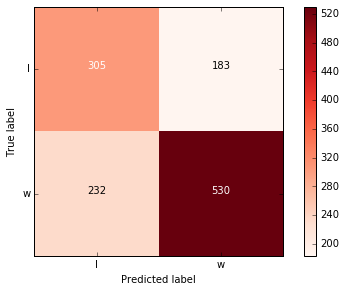

In [185]:
import itertools
from sklearn.metrics import confusion_matrix

 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm,title='Confusion matrix', classes=fit.classes_, normalize = False, cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
   # plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        
        print("Goal Features(Win-Loss),Win Streak & Team Features: Normalized confusion matrix")
    else:
        print('Goal Features(Win-Loss),Win Streak & Team Features: Confusion matrix, without normalization')

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


 
  

    
 

cnf_matrix = confusion_matrix(y_test_winloss,y_pred_winloss,labels = fit.classes_ )

plot_confusion_matrix(cnf_matrix,fit.classes_)
plt.figure()



**Normalize and do logistic Regression**

In [186]:
from sklearn.preprocessing import normalize

x_train_norm_winloss = normalize(x_train_winloss,axis=0,norm='max')
x_train_norm_winloss = pd.DataFrame(x_train_norm_winloss)

x_test_norm_winloss = normalize(x_test_winloss,axis=0,norm='max')
x_test_norm_winloss = pd.DataFrame(x_test_norm_winloss)

In [187]:
x_train_norm_winloss.columns = x_train_winloss.columns
x_test_norm_winloss.columns = x_test_winloss.columns

In [188]:
logreg = LogisticRegression()
fit = logreg.fit(x_train_norm_winloss,y_train_winloss)

In [189]:
train_acc_winloss=fit.score(x_train_norm_winloss, y_train_winloss)
test_acc_winloss=fit.score(x_test_norm_winloss,y_test_winloss)

train_acc_winloss,test_acc_winloss

(0.64694656488549618, 0.6976)

**SVM**

In [190]:
from sklearn import svm
from sklearn import preprocessing

x_train_scaled_winloss = preprocessing.scale(x_train_winloss)
x_test_scaled_winloss = preprocessing.scale(x_test_winloss)

x_train_scaled_winloss = pd.DataFrame(x_train_scaled_winloss)
x_test_scaled_winloss = pd.DataFrame(x_test_scaled_winloss)

In [191]:
x_train_scaled_winloss.columns = x_train_scaled_winloss.columns
x_test_scaled_winloss.columns = x_test_scaled_winloss.columns

In [192]:
clf_svc_winloss = svm.SVC(C=10, kernel='linear', degree=5, gamma=1e-1,)
clf_fit_winloss = clf_svc_winloss.fit(x_train_scaled_winloss, y_train_winloss)

#tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1,1e-1,1e-2,1e-3, 1e-4],
 #                    'C': [1, 10, 100, 1000]},{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},{'kernel':['poly'],'degree':[1,2,3]}]

In [193]:
train_svcacc_winloss=fit.score(x_train_scaled_winloss, y_train_winloss)
test_svcacc_winloss=fit.score(x_test_scaled_winloss,y_test_winloss)

train_svcacc_winloss, test_svcacc_winloss

(0.64217557251908397, 0.66800000000000004)

**Fit a Decision Tree and Random Forest**

In [194]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train_winloss,y_train_winloss)

In [195]:
train_acc_dtree_winloss =clf.score(x_train_winloss, y_train_winloss)
test_acc_dtree_winloss =clf.score(x_test_winloss,y_test_winloss)
train_acc_dtree_winloss,test_acc_dtree_winloss

(0.9742366412213741, 0.5968)

In [145]:
#Tuning features on Decision Tree
from sklearn.grid_search import GridSearchCV
from sklearn import tree

param_grid = { 
    
   
    'max_depth' : [10,50,100],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1, 25, 50, 100, 150],
   
    
}

dtree_winloss = tree.DecisionTreeClassifier()
CV_dtree_winloss = GridSearchCV(dtree_winloss,param_grid=param_grid)
CV_dtree_winloss.fit(x_train_winloss, y_train_winloss)
print CV_dtree_winloss.best_params_

{'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 100}


In [196]:
dtree_bestparams_winloss = tree.DecisionTreeClassifier(min_samples_split= 2, max_depth = 10, min_samples_leaf= 50)
fit_bestdtree_winloss = dtree_bestparams_winloss.fit(x_train_winloss, y_train_winloss)
train_acc_bestdtree_winloss = fit_bestdtree_winloss.score(x_train_winloss, y_train_winloss)
test_acc_bestdtree_winloss = fit_bestdtree_winloss.score(x_test_winloss,y_test_winloss)
train_acc_bestdtree_winloss,test_acc_bestdtree_winloss

(0.66984732824427484, 0.58879999999999999)

In [197]:
clf.classes_

array(['l', 'w'], dtype=object)

In [200]:
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier()
clf_forest_winloss = clf_forest.fit(x_train_winloss,y_train_winloss)

In [201]:
train_acc_forest_winloss = clf_forest_winloss.score(x_train_winloss, y_train_winloss)
test_acc_forest_winloss = clf_forest_winloss.score(x_test_winloss,y_test_winloss)
train_acc_forest_winloss,test_acc_forest_winloss

(0.96278625954198471, 0.57999999999999996)

**Tuning parameters on Random Forest**

In [202]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [50, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth ' : ['None'],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1, 25, 50, 100, 150],
    
    
}

rfc_winloss = RandomForestClassifier()
CV_rfc_winloss = GridSearchCV(rfc_winloss,param_grid=param_grid)
CV_rfc_winloss.fit(x_train_winloss, y_train_winloss)
print CV_rfc_winloss.best_params_

{'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50, 'min_samples_leaf': 25}


In [ ]:
rfc_bestparams = RandomForestClassifier(max_features='auto', min_samples_split= 2, n_estimators= 700, min_samples_leaf= 25)
fit_bestrfc_winloss = rfc_bestparams.fit(x_train_winloss, y_train_winloss)
train_acc_bestforest_winloss = fit_bestrfc_winloss.score(x_train_winloss, y_train_winloss)
test_acc_bestforest_winloss = fit_bestrfc_winloss.score(x_test_winloss,y_test_winloss)
train_acc_bestforest_winloss,test_acc_bestforest_winloss

**KNN**

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = KNeighborsClassifier(n_neighbors=7)
neigh_winloss = neigh.fit(x_train_winloss,y_train_winloss) 
#n_neighbors=7, weights = 'distance'

In [ ]:
knntrain_score_winloss = neigh_winloss.score(x_train_winloss, y_train_winloss)
knntest_score_winloss = neigh_winloss.score(x_test_winloss, y_test_winloss)
knntrain_score_winloss,knntest_score_winloss

**Gausian Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
clf_gnb_winloss = clf_gnb.fit(x_train_winloss,y_train_winloss)


In [ ]:
gnbtrain_score_winloss = clf_gnb_winloss.score(x_train_winloss, y_train_winloss)
gnbtest_score_winloss = clf_gnb_winloss.score(x_test_winloss, y_test_winloss)
gnbtrain_score_winloss,gnbtest_score_winloss

**Model for winloss and win streak, after removing the top 298 rows**

In [ ]:
df_winloss_temp = df_winloss_temp.reset_index()
df_winloss_temp.head()

In [ ]:
df_winloss_temp = df_winloss_temp.drop(['level_0'],axis = 1)

In [ ]:
len(df_winloss_temp)

In [ ]:
y_train_temp = df_winloss_temp['hometeam_outcome'][:1500]
y_test_temp = df_winloss_temp['hometeam_outcome'][1500:(len(df_winloss_temp)+1)]

In [ ]:
x_wl_temp = df_winloss_temp.loc[:,['date', 
       'HT_goalsfor', 'HT_goalsagainst', 'AT_goalsfor', 'AT_goalsagainst','HT_streak','AT_streak']]

In [ ]:
x_dummies_wl_temp = pd.get_dummies(x_wl_temp)

In [ ]:
x_dummies_wl_temp = x_dummies_wl_temp.drop('date',axis = 1)

In [ ]:
columns = ['HT_goalsfor','HT_goalsagainst','AT_goalsfor','AT_goalsagainst','HT_streak','AT_streak']
x_train_wl_temp = x_dummies_wl_temp[:1500]

x_test_wl_temp = x_dummies_wl_temp[1500:(len(x_dummies_wl_temp)+1)]

In [ ]:
x_train_wl_temp.shape,y_train_temp.shape

In [ ]:
logreg = LogisticRegression()
fit = logreg.fit(x_train_wl_temp,y_train_temp)

In [ ]:
train_acc_temp = fit.score(x_train_wl_temp,y_train_temp)
test_acc_temp = fit.score(x_test_wl_temp,y_test_temp)
#print fit.classes_
train_acc_temp,test_acc_temp

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier()
clf_forest_winloss = clf_forest.fit(x_train_wl_temp,y_train_temp)

In [ ]:
train_acc_forest_winloss = clf_forest_winloss.score(x_train_wl_temp,y_train_temp)
test_acc_forest_winloss = clf_forest_winloss.score(x_test_wl_temp,y_test_temp)
train_acc_forest_winloss,test_acc_forest_winloss

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [50, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,50,100,200],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1, 25, 50, 100, 150],
    'n_estimators' : [100,200]
    
}

rfc_winloss = RandomForestClassifier()
CV_rfc_winloss = GridSearchCV(rfc_winloss,param_grid=param_grid)
CV_rfc_winloss.fit(x_train_wl_temp,y_train_temp)
print CV_rfc_winloss.best_params_

In [ ]:
rfc_bestparams = RandomForestClassifier(max_features='sqrt', min_samples_split= 10, n_estimators= 100, min_samples_leaf= 25)
fit_bestrfc_winloss = rfc_bestparams.fit(x_train_wl_temp,y_train_temp)
train_acc_bestforest_winloss = fit_bestrfc_winloss.score(x_train_wl_temp,y_train_temp)
test_acc_bestforest_winloss = fit_bestrfc_winloss.score(x_test_wl_temp,y_test_temp)
train_acc_bestforest_winloss,test_acc_bestforest_winloss